In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint
from copy import deepcopy
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import scipy
from sklearn.metrics import auc
%matplotlib inline

# Determine growth rate of oral and gut bacteria

In [9]:
df_oral_taxa = pd.read_csv("../../databases/fHOMD/oral_typical_species.csv")
df_oral_taxa.head()

,taxon,MeanRelabunOral,PrevalenceOral,MeanRelabunGut,PrevalenceGut,species,species_binomial
0,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.550773,0.458484,0.000039,0.009404,Actinobaculum_sp_oral_taxon_183,Actinobaculum sp
1,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.143748,0.395307,0.000021,0.009404,Actinomyces_johnsonii,Actinomyces johnsonii
2,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.354643,0.402527,0.000000,0.000000,Actinomyces_massiliensis,Actinomyces massiliensis
3,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.505413,0.635379,0.000074,0.018809,Actinomyces_naeslundii,Actinomyces naeslundii
4,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.127484,0.500000,0.000110,0.034483,Actinomyces_sp_S6_Spd3,Actinomyces sp


In [10]:
df_growth = pd.read_csv("tbl_max_growth.csv")
df_growth = df_growth[df_growth.medium=="AGORA_WD"]
df_growth['species_binomial'] = [(' ').join(x.split('_')[0:2]) for x in df_growth.agoraid]
df_growth['is_oral'] = ['Yes' if x in list(df_oral_taxa.species_binomial) else 'No' for x in df_growth.species_binomial]
df_growth.head()

,agoraid,max_growth_rate,medium,species_binomial,is_oral
4908,Abiotrophia_defectiva_ATCC_49176,0.229485,AGORA_WD,Abiotrophia defectiva,No
4909,Achromobacter_xylosoxidans_A8,0.402918,AGORA_WD,Achromobacter xylosoxidans,No
4910,Achromobacter_xylosoxidans_NBRC_15126,0.217327,AGORA_WD,Achromobacter xylosoxidans,No
4911,Acidaminococcus_fermentans_DSM_20731,0.200883,AGORA_WD,Acidaminococcus fermentans,No
4912,Acidaminococcus_intestini_RyC_MR95,0.066094,AGORA_WD,Acidaminococcus intestini,No


In [11]:
df_growth.groupby('is_oral')['max_growth_rate'].agg(np.mean)

is_oral
No     0.350523
Yes    0.225570
Name: max_growth_rate, dtype: float64

In [12]:
len(df_growth[df_growth.is_oral=='Yes']),len(df_growth[df_growth.is_oral=='No'])

(60, 758)

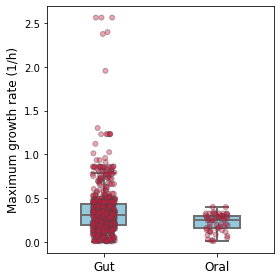

In [13]:
fig, ax = plt.subplots(figsize=(4,4))

_ = sns.boxplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                width=0.4, color="skyblue", linewidth=2, showfliers=False
               )
_ = sns.stripplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                  color="crimson", linewidth=1, alpha=0.4
                 )
_ = ax.set_xticklabels(['Gut','Oral'], fontsize=12)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Maximum growth rate (1/h)', fontsize=12)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("gut_oral_bact_growth_rate.svg", dpi=600, bbox_inches='tight')

# Model

In [17]:
def glv(y, t, eps_o, eps_g, tstop):
    B_o, B_g = y
    if t <= tstop:
        epsilon_o_prime = eps_o
        epsilon_g_prime = eps_g
    else:
        epsilon_o_prime = 1
        epsilon_g_prime = 1
    dydt = [
        alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o * epsilon_o_prime - D*B_o,
                  gamma_g * (1-B_o/K_o-B_g/K_g) * B_g * epsilon_g_prime - D*B_g
    ]
    return dydt

# Parameters

In [23]:
alpha_o = 3.10e5 # oral-gut transmission rate
K_o = 1.94e9 # carrying capacity of oral bacteria, cfu/g
K_g = 2.92e10 # carrying capacity of gut bacteria, cfu/g
gamma_o = 0.23 # maximum growth rate of oral bacteria, 1/h
gamma_g = 0.35 # maximum growht rate of gut bacteria, 1/h
D = 0.08 # fecal excretion rate, 1/h

sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,2000))
steady_state = list(sol[-1])
steady_state[0]/sum(steady_state)

0.0005053039109311233

# Plot phase diagram

In [30]:
epsilon_o = np.linspace(0,1,101)
epsilon_g = np.linspace(0,1,101)
tend = 100 # simulation time

# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,2000))
steady_state = list(sol[-1])

# add perturbations
res = []
for eps_g in epsilon_g:
    for eps_o in epsilon_o:
        tspan = np.linspace(0, tend, int(tend)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        
        # relative enrichment
        auc_rel = auc(tspan, df2.Oralf-steady_state[0]/(steady_state[0]+steady_state[1]))
        auc_abs = auc(tspan, df2.B_o-steady_state[0])
        upup = 0
        updown = 0
        downup = 0
        downdown = 0
        if auc_rel >0 and auc_abs<0:
            updown = 1
        if auc_rel >0 and auc_abs>0:
            upup = 1
        if auc_rel <0 and auc_abs<0:
            downdown = 1
        if auc_rel < 0 and auc_abs>0:
            downup=1
        res.append([eps_g, eps_o, auc_rel, auc_abs, updown, upup, downdown, downup])
df = pd.DataFrame(res, columns=['Epsilon_g','Epsilon_o','AUC_Rel','AUC_Abs','UpDown','UpUp','DownDown','DownUp'])
df.head()

,Epsilon_g,Epsilon_o,AUC_Rel,AUC_Abs,UpDown,UpUp,DownDown,DownUp
0,0.0,0.00,5.185608,-6.498514e+08,1,0,0,0
1,0.0,0.01,5.311514,-6.393179e+08,1,0,0,0
2,0.0,0.02,5.443603,-6.282736e+08,1,0,0,0
3,0.0,0.03,5.582319,-6.166808e+08,1,0,0,0
4,0.0,0.04,5.728149,-6.044981e+08,1,0,0,0


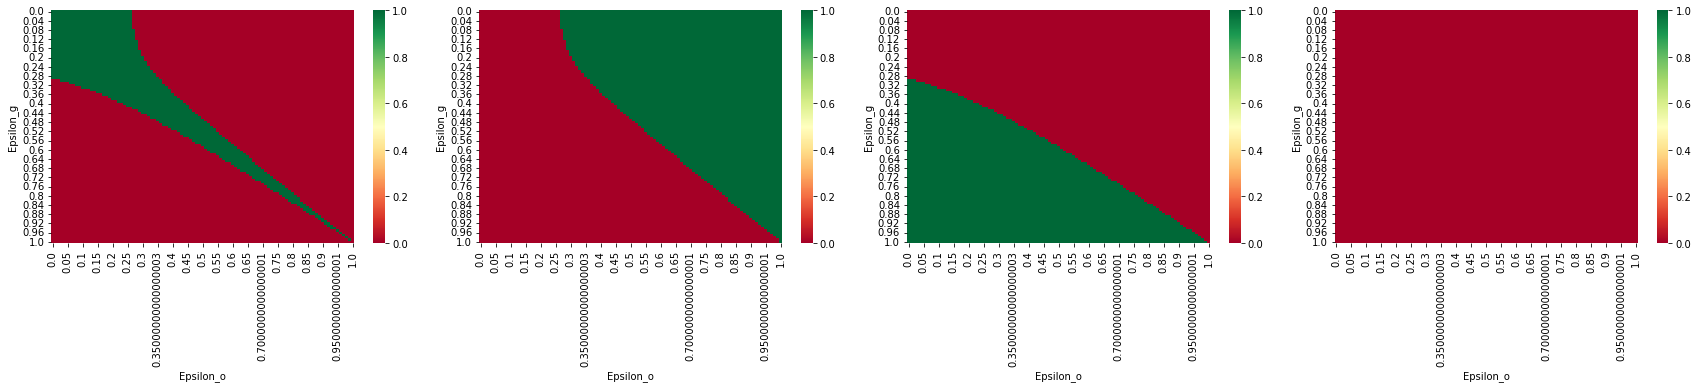

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,5.5))

for k,col in enumerate(['UpDown','UpUp','DownDown','DownUp']):
    df2plot = pd.pivot_table(df, index='Epsilon_g', columns='Epsilon_o', values=col)
    _ = sns.heatmap(df2plot, ax=ax[k], cmap="RdYlGn", vmin=0, vmax=1, linewidth=0, linecolor='gray') 

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("heatmap_satisfied.png", dpi=600, bbox_inches='tight')

# Plot oral load for a variety of Eo and Eg

In [33]:
epsilon_o = np.linspace(0,1,5)
epsilon_g = np.linspace(0,1,5)
tend = 100 # simulation time

# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,2000))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Gutf'] = 1-df2['Oralf']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['Epsilon_diff'] = eps_o-eps_g
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Gutf,Epsilon_o,Epsilon_g,Epsilon_diff
0,0.0,1.130208e+07,2.235560e+10,2.236690e+10,0.000505,0.999495,0.0,0.0,0.0
1,1.0,1.073106e+07,2.063682e+10,2.064755e+10,0.000520,0.999480,0.0,0.0,0.0
2,2.0,1.020394e+07,1.905019e+10,1.906039e+10,0.000535,0.999465,0.0,0.0,0.0
3,3.0,9.717351e+06,1.758554e+10,1.759526e+10,0.000552,0.999448,0.0,0.0,0.0
4,4.0,9.268169e+06,1.623350e+10,1.624277e+10,0.000571,0.999429,0.0,0.0,0.0


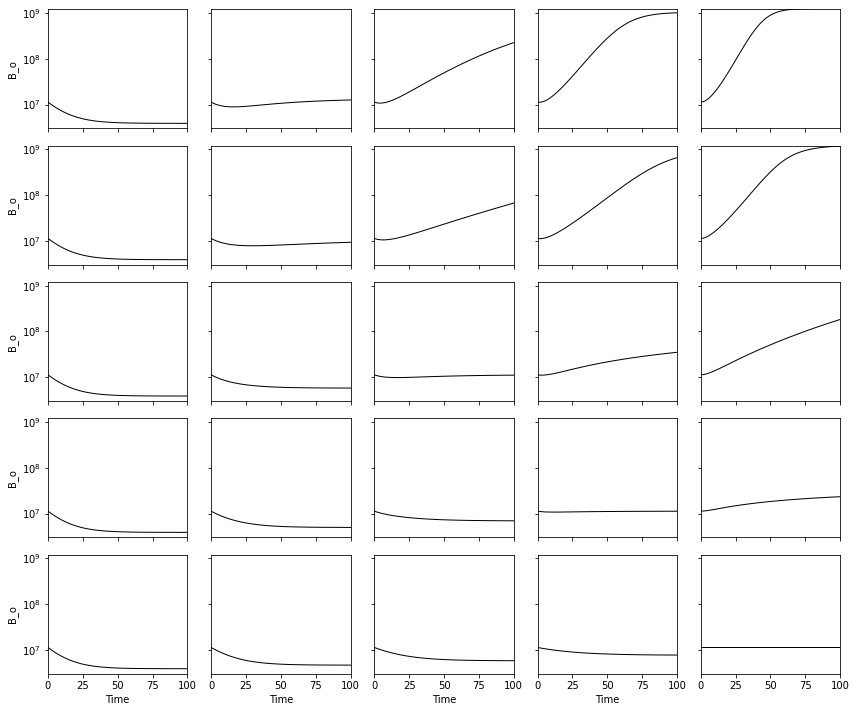

In [41]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12,10), sharex=True, sharey=True)

for i,eps_g in enumerate(epsilon_g):
    for j,eps_o in enumerate(epsilon_o):
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)].sort_values('Time')
        _ = sns.lineplot(x="Time", y='B_o', data=curr_df, ax=ax[i,j], zorder=-10, linewidth=1, color='k')
        if ax[i,j].get_legend() is not None:
            _ = ax[i,j].get_legend().remove()
_ = ax[i,j].set_xlim([0,100])
_ = ax[i,j].set_yscale('log')
_ = ax[i,j].minorticks_off()
_ = ax[i,j].set_xlabel('', fontsize=15)
_ = ax[i,j].set_ylabel('', fontsize=15)
_ = ax[i,j].set_ylim([3e6,1.2e9])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("grid_search_oral_load.svg", dpi=600, bbox_inches='tight')

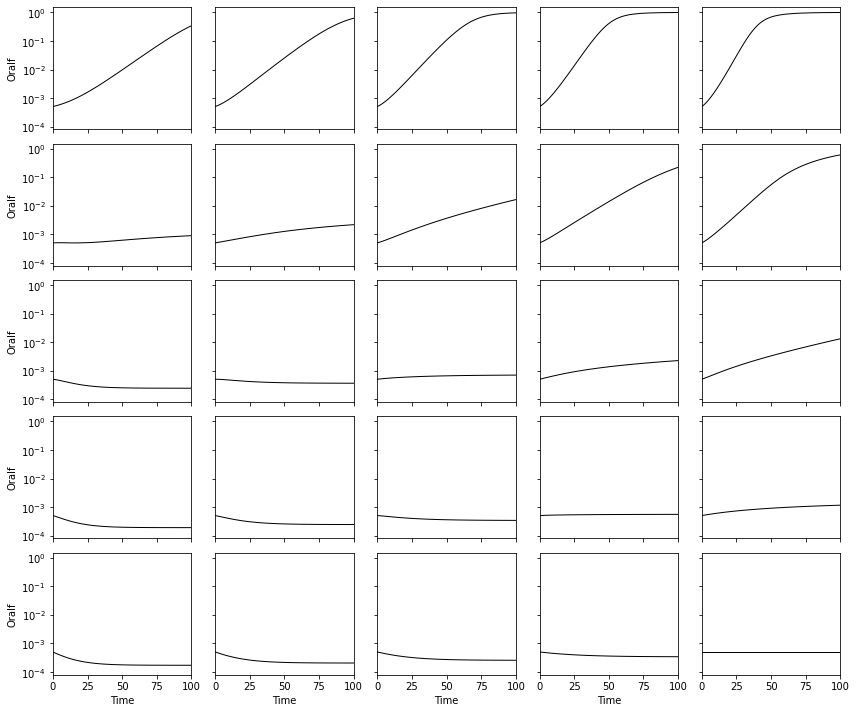

In [40]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12,10), sharex=True, sharey=True)

for i,eps_g in enumerate(epsilon_g):
    for j,eps_o in enumerate(epsilon_o):
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)].sort_values('Time')
        _ = sns.lineplot(x="Time", y='Oralf', data=curr_df, ax=ax[i,j], zorder=-10, linewidth=1, color='k')
        #_ = ax[i,j].plot([0,100],[steady_state[0],steady_state[0]],'k--')
        if ax[i,j].get_legend() is not None:
            _ = ax[i,j].get_legend().remove()
_ = ax[i,j].set_xlim([0,100])
_ = ax[i,j].set_yscale('log')
_ = ax[i,j].minorticks_off()
_ = ax[i,j].set_xlabel('', fontsize=15)
_ = ax[i,j].set_ylabel('', fontsize=15)
_ = ax[i,j].set_ylim([8e-5,1.5])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("grid_search_oral_fraction.svg", dpi=600, bbox_inches='tight')